In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

In [2]:
from pathlib import Path
from fastai.basic_train import load_learner

In [3]:
model_path = Path("/home/jupyter/models/")
output_path = Path("home/jupyter/data/style_transfers")

In [4]:
learner = load_learner(path = model_path, file = "vgg19_age_2.pkl")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
cnn = learner.model[0][0]

In [7]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [8]:
content_img = image_loader("/home/jupyter/data/" + "markus_pp.jpg")
style_img = image_loader("/home/jupyter/data/" + "hendrix.jpg")

style_img = style_img[:, :3, :, :512]
content_img.shape
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [9]:
style_injects = [f'conv-{i}' for i in range(12)]
content_injects = ['conv-3', "conv-4", "conv-5"]

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [11]:
style_module = StyleTransferModule(arch, content_img, content_injects, style_img, style_injects)

In [12]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


In [15]:
#encode in strings
#import trained model
#run style transfer with config
#save input, output
#save config as JSON
#callback for 'run style transfer'


#vgg19_age_2.pkl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = Path("/home/jupyter/models/")
style_img = style_img[:, :3, :, :512]


batch_config = {
    #all relations and tweaking is assumed a cartesian product of params
    "model": "vgg19_age_2.pkl", #TODO: model_meta: information about models trained...
    
    "style_content_pairs": [ #can run multiple pair
        ("/home/jupyter/data/" + "hendrix.jpg", 
         "/home/jupyter/data/" + "markus_pp.jpg"
         )
    ],
    "style_transfer_optim_v": 0.1,
    "style_injects": [[f'conv-{i}' for i in range(12)]],
    "content_injects": ["content_5"], #doesn't really make a difference
    "epochs": 300,
    "save_every_x_epoch": 50, #non-linear might be better
    "tv_weights": 0.001,

}


In [45]:
from datetime import datetime
from pathlib import Path
import json
from PIL import Image

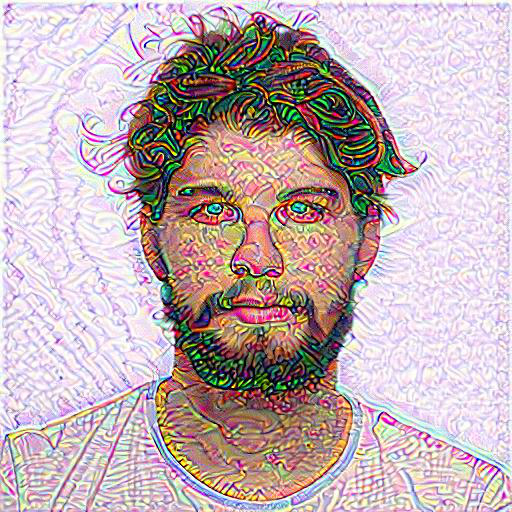

In [46]:
#Image.open("/home/jupyter/data/style_transfers/50_SL_22092_CL_476")

In [105]:
#add %timer to params -- know how long the training took
def hyperparam_traverse(config, model_path="/home/jupyter/models/", output_path="/home/jupyter/data/style_transfers/"):
   
    #SETUP ARCH
    learner = load_learner(path = model_path, file = "vgg19_age_2.pkl")
    cnn = learner.model[0][0]
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))
    
    #iteration logic later
    style_p, content_p = config["style_content_pairs"][0]
    style_img = image_loader(style_p)
    style_img = style_img[:, :3, :, :512]

    content_img = image_loader(content_p)
    input_img = content_img.clone()

    assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
    
    

    
    #luckily content doesn't vary...
    content_injects = config["content_injects"]

    #for loop here over permutations
    for idx, style_inject in enumerate(config["style_injects"]):
       # style_injects = config["style_injects"]
        folder_name = "try"
        for s in style_inject:
            folder_name += "-" + s.split("-")[1]
        folder_name += "/"
        p = Path(output_path + folder_name)
        print(p)
        p.mkdir(parents=True, exist_ok=True)
        conf = config.copy()
        conf['date'] = datetime.now().strftime("%m_%d_%Y, %H:%M:%S")
        conf["losses"] = []

        def tap_closure(epoch, img, style_loss, content_loss):                
            if epoch % 50 != 0: 
                return
            image = img.cpu().clone()  # we clone the tensor to not do changes on it
            image = image.squeeze(0)      # remove the fake batch dimension
            image = unloader(image)
            SL = str(round(style_loss))
            CL = str(round(content_loss))
            fname = str(epoch) + "_SL_" + SL + "_CL_" + CL
            if epoch == config["epochs"]:
                image.save(p / fname + "_final", JPEG)
            else:
                image.save(p / fname, 'JPEG')
            conf["losses"].append({"epoch": epoch, "style_loss": SL, "content_loss": CL }) #TODO variation loss

        print(str(style_inject))
        output = style_module.run_style_transfer(input_img, num_steps=config["epochs"], tv_weight=0.001, callback=tap_closure, verbose=False)
    
                     
        #SAVE CONFIG
        meta = "config.json"
        filepath = p / meta
        #json.dump(conf, default=lambda o: o.__dict__, indent=4)
        with open(filepath, 'w') as outfile:
            json.dump(conf, outfile)
    
    plt.figure()
    imshow(output, title='Output Image')
    
    return output
    

In [98]:
x = []
x.append({"a":5})
x

[{'a': 5}]

/home/jupyter/data/style_transfers/try-0-1-2-3-4-5-6-7-8-9-10-11
Optimizing...


tensor([[[[0.9003, 0.8144, 0.6768,  ..., 0.9598, 0.9948, 0.9619],
          [0.9635, 0.9933, 0.9946,  ..., 0.9419, 0.9925, 0.9733],
          [0.8860, 0.9967, 0.9442,  ..., 0.7196, 0.7112, 0.7920],
          ...,
          [0.6638, 0.8765, 0.9313,  ..., 0.8672, 0.7663, 0.8228],
          [0.7218, 0.8085, 0.9074,  ..., 0.7366, 0.6545, 0.7470],
          [0.6198, 0.7083, 0.7322,  ..., 0.8094, 0.6835, 0.7328]],

         [[0.9836, 0.9881, 0.8027,  ..., 0.9471, 0.9947, 0.8932],
          [0.9834, 0.9711, 0.9905,  ..., 0.9892, 0.9703, 0.9858],
          [0.9915, 0.9631, 0.9902,  ..., 0.9997, 0.9966, 0.9963],
          ...,
          [0.5038, 0.8093, 0.8959,  ..., 0.9743, 0.9930, 0.9869],
          [0.5064, 0.7268, 0.8176,  ..., 0.9886, 0.9906, 0.9883],
          [0.3705, 0.5677, 0.5854,  ..., 0.7661, 0.8723, 0.7741]],

         [[0.9441, 0.9331, 0.8025,  ..., 0.9949, 0.9979, 0.9417],
          [0.9910, 0.9880, 0.8373,  ..., 0.9988, 0.9909, 0.9949],
          [0.9901, 0.9733, 0.8844,  ..., 0

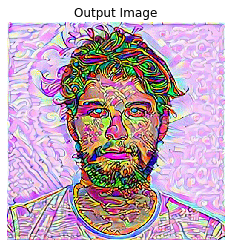

In [55]:
hyperparam_traverse(batch_config)

In [67]:
from itertools import product, chain, combinations, permutations

(6, 10, 13)

In [84]:
from random import sample 
conv_layer_indices = list(range(0, 16))

In [92]:
str(['conv-1', 'conv-3', 'conv-6', 'conv-9', 'conv-14', 'conv-15'])

"['conv-1', 'conv-3', 'conv-6', 'conv-9', 'conv-14', 'conv-15']"

In [106]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
layer_combos =  [list(subs) for subs in powerset(conv_layer_indices) if subs != ()]
samp = sample(layer_combos,k=30)


samp_layers = [
    [f'conv-{i}' for i in subsamp]
    for subsamp in samp]


In [ ]:
bc = batch_config.copy()
bc["style_injects"] = samp_layers
hyperparam_traverse(bc)

/home/jupyter/data/style_transfers/try-0-3-6-8-10-13-14-15
['conv-0', 'conv-3', 'conv-6', 'conv-8', 'conv-10', 'conv-13', 'conv-14', 'conv-15']
Optimizing...
/home/jupyter/data/style_transfers/try-1-4-6-7-9-10-13-15
['conv-1', 'conv-4', 'conv-6', 'conv-7', 'conv-9', 'conv-10', 'conv-13', 'conv-15']
Optimizing...
/home/jupyter/data/style_transfers/try-2-4-5-7-9-10-15
['conv-2', 'conv-4', 'conv-5', 'conv-7', 'conv-9', 'conv-10', 'conv-15']
Optimizing...
/home/jupyter/data/style_transfers/try-0-3-6-7-8-12-14
['conv-0', 'conv-3', 'conv-6', 'conv-7', 'conv-8', 'conv-12', 'conv-14']
Optimizing...
/home/jupyter/data/style_transfers/try-0-2-5-6-7-9-10-11
['conv-0', 'conv-2', 'conv-5', 'conv-6', 'conv-7', 'conv-9', 'conv-10', 'conv-11']
Optimizing...
